In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from itertools import product, chain
import importlib

import trainer, data, models

/Users/ralph/.venvs/d2dl/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [267]:
importlib.reload(trainer)
importlib.reload(data)
importlib.reload(models)

<module 'models' from '/Users/ralph/projects/d2dl/models.py'>

In [268]:
kaggle_housing_dataset = data.kaggle_housing()

In [249]:
class LinearRegression(nn.Sequential):
    def __init__(
            self,
            output_bias_mean,
            output_bias_stddev,
            hidden_dim: int = 100,
            num_outputs: int = 1,
        ):
        super().__init__(
            nn.LazyLinear(hidden_dim),
            nn.ReLU(),
            nn.LazyLinear(hidden_dim),
            nn.ReLU(),
            nn.LazyLinear(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_outputs)
        )

        nn.init.normal_(
            self[-1].bias, 
            mean=output_bias_mean,
            std=1.0
        ) 

    def forward_scaled(self, input):
        return torch.exp(self(input))

In [250]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [251]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(pred, actual))

In [252]:
provider = lambda hyperparams: trainer.Trainer(
    model=LinearRegression(
        output_bias_mean=hyperparams.model["output_bias_mean"],
        output_bias_stddev=hyperparams.model["output_bias_stddev"],
        hidden_dim=hyperparams.model["hidden_dim"],
        num_outputs=1,
    ),
    dataset=kaggle_housing_dataset,
    # loss=RMSLELoss,
    loss=RMSELoss,
    opt=torch.optim.SGD,
    hyperparameters=hyperparams
)

In [253]:
model_trainer = provider(trainer.Hyperparameters(
    opt=dict(
        lr = 3e-2
    ),
    model=dict(
        output_bias_mean = kaggle_housing_dataset.train.dataframe["SalePrice"].mean(),
        output_bias_stddev = kaggle_housing_dataset.train.dataframe["SalePrice"].std(),
        hidden_dim = 300
    ),
    general=dict(
        num_epochs = 100,
        batch_size = 64
    )
))

/Users/ralph/.venvs/d2dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [254]:
train_result = model_trainer.train(16)

loss tensor(12.3385, grad_fn=<MeanBackward0>) tensor(12.0098) tensor(0.5647, grad_fn=<SqrtBackward0>)
loss tensor(12.3078, grad_fn=<MeanBackward0>) tensor(12.0652) tensor(0.4582, grad_fn=<SqrtBackward0>)
loss tensor(12.2789, grad_fn=<MeanBackward0>) tensor(12.0013) tensor(0.5295, grad_fn=<SqrtBackward0>)
loss tensor(12.2521, grad_fn=<MeanBackward0>) tensor(12.0380) tensor(0.4887, grad_fn=<SqrtBackward0>)
loss tensor(12.2297, grad_fn=<MeanBackward0>) tensor(12.0303) tensor(0.4402, grad_fn=<SqrtBackward0>)
loss tensor(12.2022, grad_fn=<MeanBackward0>) tensor(12.0220) tensor(0.3961, grad_fn=<SqrtBackward0>)
loss tensor(12.1754, grad_fn=<MeanBackward0>) tensor(12.1067) tensor(0.4062, grad_fn=<SqrtBackward0>)
loss tensor(12.1664, grad_fn=<MeanBackward0>) tensor(12.0498) tensor(0.4362, grad_fn=<SqrtBackward0>)
loss tensor(12.1552, grad_fn=<MeanBackward0>) tensor(12.0406) tensor(0.4331, grad_fn=<SqrtBackward0>)
loss tensor(12.1358, grad_fn=<MeanBackward0>) tensor(11.9909) tensor(0.4106, grad_

In [255]:
train_result

,train,val
0,0.564726,0.508347
1,0.396118,0.344989
2,0.418756,0.328195
3,0.446623,0.373027
4,0.403352,0.330249
...,...,...
95,0.162007,0.123944
96,0.122360,0.143720
97,0.086828,0.102791
98,0.088264,0.233073


<Axes: >

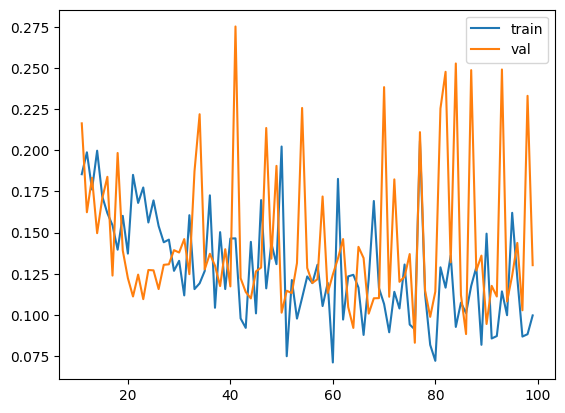

In [256]:
train_result[1:][10:].plot()

In [257]:
val_x = torch.stack([
    kaggle_housing_dataset.val[i][0]
    for i in range(len(kaggle_housing_dataset.val))
])

In [258]:
val_y = torch.stack([
    kaggle_housing_dataset.val[i][1]
    for i in range(len(kaggle_housing_dataset.val))
])

In [259]:
model_y = model_trainer.model(val_x)

In [260]:
val_df = pd.DataFrame(
    torch.stack([
        torch.exp(torch.flatten(model_y.detach())),
        torch.exp(torch.flatten(val_y))
    ], dim = 1),
    columns=["pred", "val"]
)

In [261]:
val_df

,pred,val
0,122887.859375,122900.046875
1,227226.390625,231999.890625
2,160109.625000,147999.968750
3,206664.406250,213250.062500
4,247469.484375,240000.031250
...,...,...
287,175132.562500,179999.937500
288,156237.890625,157500.078125
289,240611.468750,240000.031250
290,198782.859375,210000.000000


<Axes: xlabel='pred', ylabel='val'>

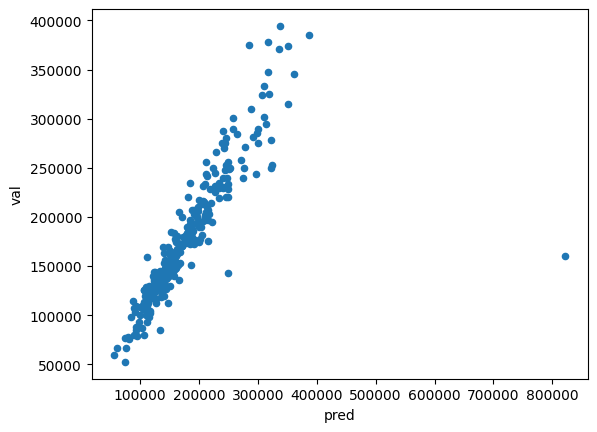

In [262]:
val_df.plot(kind="scatter", x="pred", y="val")

In [263]:
loss = RMSELoss()

In [264]:
loss(
    torch.flatten(model_y.detach()),
    torch.flatten(val_y)
)

tensor(0.1434)

In [269]:
test_y = torch.stack([
    kaggle_housing_dataset.test[i][0]
    for i in range(len(kaggle_housing_dataset.test))
])

In [273]:
preds = model_trainer.model.forward_scaled(test_y)

In [280]:
test_preds_df = pd.DataFrame({
    "Id": kaggle_housing_dataset.test.dataframe["Id"],
    "SalePrice": torch.flatten(preds).detach()
})

In [281]:
test_preds_df.to_csv("datasets/kaggle_housing/test_preds/20230107.csv", index=False)